In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
% matplotlib inline
import healpy as hp

In [2]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils

In [3]:
# Set user region for 
ra = [268.17160102]
dec = [-29.27952102]
lsst_radius_fov = 1.75
slicer = slicers.UserPointsSlicer(ra, dec, radius=lsst_radius_fov)

In [4]:
mjds_of_obs = [[60719, 60791],
              [60903, 60975],
              [61449, 61521],
              [61633, 61705],
              [62545, 62617],
              [62729, 62801]]
constraint = ''
for mjdr in mjds_of_obs:
    constraint += '(expMJD between %f and %f) or ' % (mjdr[0], mjdr[1])
constraint = constraint.rstrip(' or ')
print constraint

(expMJD between 60719.000000 and 60791.000000) or (expMJD between 60903.000000 and 60975.000000) or (expMJD between 61449.000000 and 61521.000000) or (expMJD between 61633.000000 and 61705.000000) or (expMJD between 62545.000000 and 62617.000000) or (expMJD between 62729.000000 and 62801.000000)


In [5]:
countmetric = metrics.CountMetric('expMJD')
printmetric = metrics.PassMetric(cols=['expMJD', 'fieldRA', 'fieldDec', 'filter', 'FWHMgeom', 'fiveSigmaDepth'])

In [6]:
runName = 'minion_1016'
opsdb = db.OpsimDatabase(os.path.join('db', runName + '_sqlite.db'))

In [7]:
metadata = 'LSST_WFIRST_overlap'
count = mmb.MetricBundle(countmetric, slicer, constraint, runName=runName, metadata=metadata, 
                         summaryMetrics=[metrics.SumMetric()])
savedata = mmb.MetricBundle(printmetric, slicer, constraint, runName=runName, metadata=metadata)

In [8]:
bg = mmb.MetricBundleGroup({'count': count, 'save': savedata}, opsdb, resultsDb=None)

In [9]:
bg.runAll()
bg.writeAll()

Querying database with constraint (expMJD between 60719.000000 and 60791.000000) or (expMJD between 60903.000000 and 60975.000000) or (expMJD between 61449.000000 and 61521.000000) or (expMJD between 61633.000000 and 61705.000000) or (expMJD between 62545.000000 and 62617.000000) or (expMJD between 62729.000000 and 62801.000000)
Found 296508 visits
Running:  ['count', 'save']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Re-saving metric bundles.


In [10]:
count.metricValues

masked_array(data = [--],
             mask = [ True],
       fill_value = -666.0)

In [11]:
bundle = mmb.MetricBundle(countmetric, slicers.HealpixSlicer(nside=64), constraint, 
                          runName=runName, metadata=metadata)
bg = mmb.MetricBundleGroup({0: bundle}, opsdb, resultsDb=None)
bg.runAll()
bg.writeAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database with constraint (expMJD between 60719.000000 and 60791.000000) or (expMJD between 60903.000000 and 60975.000000) or (expMJD between 61449.000000 and 61521.000000) or (expMJD between 61633.000000 and 61705.000000) or (expMJD between 62545.000000 and 62617.000000) or (expMJD between 62729.000000 and 62801.000000)
Found 296508 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Re-saving metric bundles.


This is the location of the fields observed during the WFIRST microlensing campaigns.


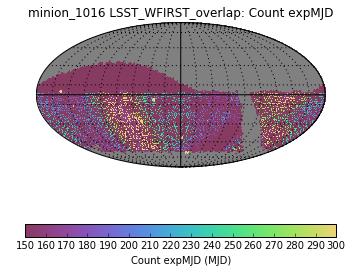

In [12]:
# Plot where pointings are during this period of time.
bundle.setPlotDict({'colorMin': 150, 'colorMax':300})
fig = bundle.plot(plotFunc=plots.HealpixSkyMap())
print "This is the location of the fields observed during the WFIRST microlensing campaigns."

In [13]:
# Where is the WFIRST field?
simData = np.array([(np.radians(ra), np.radians(dec))], dtype=[('fieldRA', float), ('fieldDec', float)])
wfirst = mmb.MetricBundle(metrics.CountMetric('fieldRA'), slicers.HealpixSlicer(nside=64), constraint='', 
                          runName=runName, metadata=metadata)
bg = mmb.MetricBundleGroup({0: wfirst}, dbObj=None, resultsDb=None)
bg.setCurrent(constraint='')
bg.runCurrent(constraint='', simData=simData)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Running:  [0]


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:105: UserWarning: Warning: dbObj should be an instantiated Database (or child) object.
  warnings.warn('Warning: dbObj should be an instantiated Database (or child) object.')


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [14]:
both = mmb.MetricBundle(metrics.CountMetric(), slicers.HealpixSlicer(nside=64), constraint='', runName=runName,
                       metadata=metadata)
mval = wfirst.metricValues.filled(0) * -1000 + bundle.metricValues.filled(0)
mask = wfirst.metricValues.mask & bundle.metricValues.mask
both.metricValues = ma.MaskedArray(data=mval, mask=mask, fill=hp.UNSEEN)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


The WFIRST field will appear as a dark point in this map, in the center of the GP.


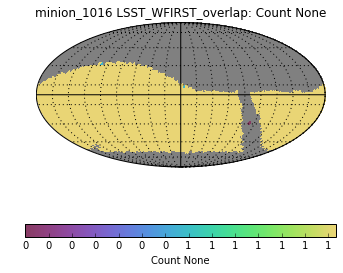

In [15]:
both.setPlotDict({'colorMin': 1, 'colorMax':1})
both.plot(plotFunc=plots.HealpixSkyMap())
print "The WFIRST field will appear as a dark point in this map, in the center of the GP."

In [16]:
# How to read back in the data from the metric file?
import lsst.sims.maf.metricBundles as mmb

runName = 'minion_1016'
metadata = 'LSST_WFIRST_overlap'
pointingdata = mmb.createEmptyMetricBundle()
fileName = runName + '_Pass_expMJD_fieldRA_fieldDec_filter_FWHMgeom_fiveSigmaDepth_LSST_WFIRST_overlap_USER.npz'
pointingdata.read(fileName)

In [21]:
# Example accessing data:
print pointingdata.metricValues.data[0]   # None here, because there were no overlapping pointings in minion_1016.

None
